# Тетрадка 3. SARSA. Q-обучение. DQN

Мы рассмотрим алгоритмы управления **on-policy** и **off-policy**. Начнем применять нейронные сети для задач обучения с подкреплением на примере DQN.

## Содержание:

1. [Вспомним Gymnasium](#gym)
2. [SARSA](#sarsa)
3. [Q-обучение](#qlearn)
4. [Deep Q Network](#dqn)
5. [DQN with Experience Replay](#dqnrep)


In [ ]:
# @title Установка зависимостей

try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 19.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 2.5 MB/s eta 0:00:00


In [ ]:
# @title Импортирование зависимостей

import time
import glob
import io
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML
import gymnasium as gym
from gymnasium.wrappers.record_video import RecordVideo
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import torch
import torch.nn as nn
from collections import deque

def show_video(folder="./video"):
    mp4list = glob.glob(folder + '/*.mp4')
    if len(mp4list) > 0:
        mp4 = sorted(mp4list, key=lambda x: x[-15:], reverse=True)[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def show_progress(rewards_batch, log):
    """
    Удобная функция, которая отображает прогресс обучения.
    """
    mean_reward = np.mean(rewards_batch)
    log.append(mean_reward)

    clear_output(True)
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(log, label='Mean rewards')
    plt.legend(loc=4)
    plt.show()

# 1. Вспомним Gymnasium <a name = 'gym'></a>

Будем рассматривать среду [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/).

In [ ]:
def video_episode(env_name, policy=None):
    # создаем среду с ограничением на число шагов в среде
    env = gym.make(env_name, render_mode="rgb_array", max_episode_steps=250)
    # добавляем визуализацию
    env = RecordVideo(env, f"./video", name_prefix=str(int(time.time())))

    # проводим инициализацию и запоминаем начальное состояние
    s, _ = env.reset()
    done = False

    while not done:
        # выполняем действие, получаем s, r, term, trunc, info
        if policy:
            s, r, terminated, truncated, _ = env.step(policy(s))
        else:
            s, r, terminated, truncated, _ = env.step(env.action_space.sample())
        done = terminated or truncated

    env.close()
    show_video()

In [ ]:
video_episode("Taxi-v3")

Moviepy - Building video /content/video/1711039863-episode-0.mp4.
Moviepy - Writing video /content/video/1711039863-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/1711039863-episode-0.mp4


Как определить пространство действий и пространство состояний среды Gymnasium?

In [ ]:
env = gym.make("Taxi-v3", render_mode="rgb_array", max_episode_steps=250)
s, info = env.reset()

Посмотрим, на что способна случайная стратегия.

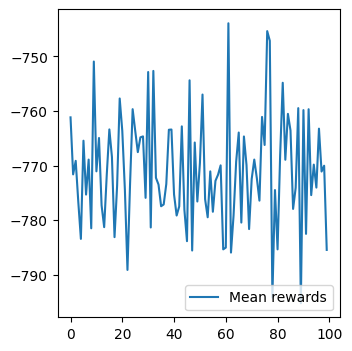

Episode: 10000, Reward: -677


In [ ]:
env = gym.make("Taxi-v3", render_mode='rgb_array')
env.reset()
log = []
rewards_batch = []
episodes_number = 10000

for episode in range(1, episodes_number + 1):
    s, _ = env.reset()
    r, episode_reward = 0, 0
    done = False

    while not done:
        a = env.action_space.sample()
        # выполняем действие в среде
        next_s, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        s = next_s
        episode_reward += r

    rewards_batch.append(episode_reward)
    if episode % 100 == 0:
        show_progress(rewards_batch, log)
        rewards_batch = []
        print(f"Episode: {episode}, Reward: {episode_reward}")

## Задание

Создайте таблицу из нулей, используя информацию из среды о количестве состояний и действий.

In [ ]:
def initialize_q_table(observation_space_n, action_space_n):
    # Q = [state][action]
    ####### Здесь ваш код ########
    Q = np.zeros((observation_space_n, action_space_n))
    ##############################
    return Q

In [ ]:
# Добавить проверку таблицы - размеры, тип.
n_states, n_actions = 3, 5
Q = initialize_q_table(n_states, n_actions)
assert isinstance(Q, np.ndarray) and len(Q.shape) == 2, 'результат должен быть 2D нумпаевским вектором'
assert Q.shape[0] == n_states and Q.shape[1] == n_actions, 'проверь размерности: [N состояний][M действий]'
assert not Q.any(), 'инициализация должна быть нулями'

## Задание

Напишите код для epsilon-жадного выбора действия:

In [ ]:
def select_action_eps_greedy(Q, state, epsilon):
    # выбираем действие, используя eps-greedy исследование среды:
    # 1) с вероятностью epsilon выбираем случайное действие,
    # 2) иначе выбираем действие жадно
    # action =
    ####### Здесь ваш код ########
    if np.random.random() > epsilon:
        action = np.argmax(Q[state])
    else:
        action = np.random.choice(Q.shape[1])
    ##############################
    return action

# 2. SARSA <a name = 'sarsa'></a>

Sutton, R. S., Barto, A. G. (2018 ). Reinforcement Learning: An Introduction. The MIT Press. p. 130.

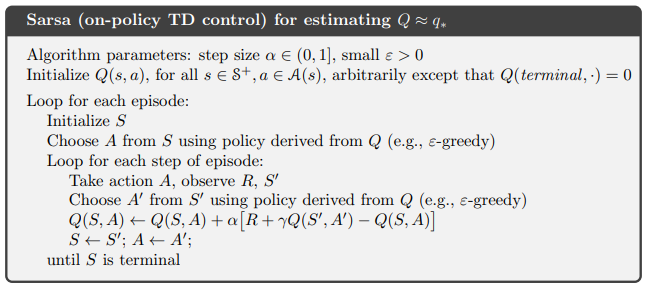

## Задание

Допишите SARSA обновление Q функции.

In [ ]:
def update_Q_SARSA(Q, s, a, r, next_s, next_a, alpha, gamma):
    # посчитайте TD ошибку
    # td_error =
    ####### Здесь ваш код ########
    td_error = r + gamma * Q[next_s, next_a] - Q[s, a]
    ##############################

    # обновление Q-функции
    Q[s, a] += alpha * td_error

Обучение и управление по SARSA:

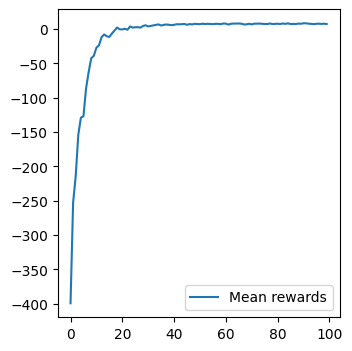

Episode: 10000, Reward: 10, Eps: 0.001246427204280841


In [ ]:
# определяем память, в которой будет храниться Q(s,a)
Q = initialize_q_table(env.observation_space.n, env.action_space.n)
log = []
rewards_batch = []

# гиперпараметры алгоритма
alpha = 0.1
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.95
episodes_number = 10000

for episode in range(1, episodes_number + 1):
    s, _ = env.reset()

    r, episode_reward = 0, 0
    done = False
    a = select_action_eps_greedy(Q, s, epsilon)

    while not done:
        # выполняем действие в среде
        next_s, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated

        next_a = select_action_eps_greedy(Q, next_s, epsilon)
        update_Q_SARSA(Q, s, a, r, next_s, next_a, alpha, gamma)

        s = next_s
        a = next_a
        episode_reward += r

    rewards_batch.append(episode_reward)
    if episode % 100 == 0:

        show_progress(rewards_batch, log)
        rewards_batch = []
        print(f"Episode: {episode}, Reward: {episode_reward}, Eps: {epsilon}")
        epsilon *= epsilon_decay

assert log[-1] > -10, log[-1]

In [ ]:
video_episode("Taxi-v3", lambda x: select_action_eps_greedy(Q, x, 0))

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/video/1711041146-episode-0.mp4.
Moviepy - Writing video /content/video/1711041146-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/1711041146-episode-0.mp4


# 3. Q-обучение <a name = 'qlearn'></a>

Sutton, R. S., Barto, A. G. (2018 ). Reinforcement Learning: An Introduction. The MIT Press. p. 131.

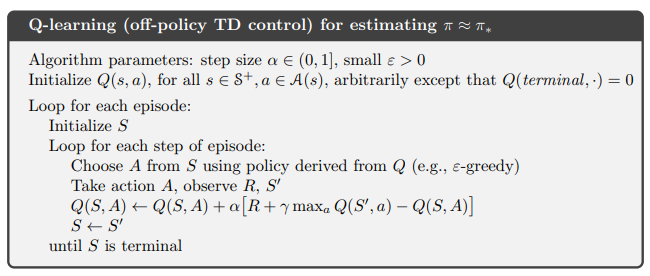

## Задание

Напишите код для формулы Q-обновления.

In [ ]:
def update_Q(Q, s, a, r, next_s, alpha, gamma):
    # вычислите V(next_s) - estimate of optimal future value
    # V_ns =
    ####### Здесь ваш код ########
    V_ns = np.max(Q[next_s])
    ##############################

    # посчитайте TD ошибку
    # td_error =
    ####### Здесь ваш код ########
    td_error = r + gamma * V_ns - Q[s, a]
    ##############################

    # обновление Q-функции
    Q[s, a] += alpha * td_error

Ниже представлен код для Q-обучения. В чем отличие от SARSA итераций?

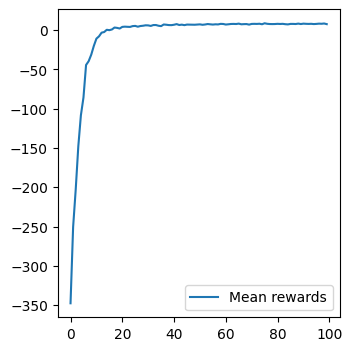

Episode: 10000, Reward: 6, Eps: 0.001246427204280841


In [ ]:
# определяем память, в которой будет храниться Q(s,a)
Q = initialize_q_table(env.observation_space.n, env.action_space.n)
log = []
rewards_batch = []

# гиперпараметры алгоритма
alpha = 0.1
gamma = 0.9
epsilon = 0.2
epsilon_decay = 0.95
episodes_number = 10000

for episode in range(1, episodes_number + 1):
    s, _ = env.reset()

    r, episode_reward = 0, 0
    done = False

    while not done:

        a = select_action_eps_greedy(Q, s, epsilon)

        next_s, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated

        update_Q(Q, s, a, r, next_s, alpha, gamma,)

        s = next_s
        episode_reward += r

    rewards_batch.append(episode_reward)
    if episode % 100 == 0:
        show_progress(rewards_batch, log)
        rewards_batch = []
        print(f"Episode: {episode}, Reward: {episode_reward}, Eps: {epsilon}")
        epsilon *= epsilon_decay

assert log[-1] >= -10

## Интерпретация результатов:
Если все сделано правильно, то график должен выйти на плато около 0. Значение вознаграждение будет в диапазоне [-5, 10], за счет случайного выбора начальной позиции такси и пассажира. Попробуйте изменить гиперпараметры и сравните результаты.

# 4. Deep Q Network <a name = 'dqn'></a>

Будем использовать библиотеку [pytorch](https://pytorch.org/) для обучения нейронной сети, хотя можно использовать и любую другую библиотеку (например, [tensorflow](https://www.tensorflow.org/), [flax](https://github.com/google/flax)).

Зачем нужны нейронные сети в RL?

Рассмотрим среду [``CartPole-v1``](https://gymnasium.farama.org/environments/classic_control/cart_pole/). На данном этапе мы ограничены, и можем использовать только дискретное пространство действий.

<img src="https://www.researchgate.net/publication/362568623/figure/fig5/AS:1187029731807278@1660021350587/Screen-capture-of-the-OpenAI-Gym-CartPole-problem-with-annotations-showing-the-cart.png" width=500/>

In [ ]:
env = gym.make("CartPole-v1")
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
print(f'Action_space: {n_actions} \nState_space: {state_dim}')
env.close()

Action_space: 2 
State_space: (4,)


Т.к. описание состояния в задаче с маятником представляет собой не "сырые" признаки, а уже предобработанные (координаты, углы), нам не нужна для начала сложная архитектура, начнем с такой:
<img src="https://raw.githubusercontent.com/Tviskaron/mipt/master/2020/RL/figures/DQN.svg" width=500>

Для начала попробуйте использовать только полносвязные слои (``torch.nn.Linear``) и простые активационные функции (``torch.nn.ReLU``).

## Задание

Допишите код, инициализирующий полносвязную нейронную сеть с 3-мя скрытыми слоями.

In [ ]:
def create_network(input_dim, hidden_dims: list[int], output_dim):
    # network = nn.Sequential(
    #    torch.nn.Linear(input_dim, ...),
    #    torch.nn.ReLU(),
    #    ...
    # )
    # add 3 layers!
    ####### Здесь ваш код ########
    network = nn.Sequential(
       torch.nn.Linear(input_dim, hidden_dims[0]),
       torch.nn.ReLU(),
       torch.nn.Linear(hidden_dims[0], hidden_dims[1]),
       torch.nn.ReLU(),
       torch.nn.Linear(hidden_dims[1], output_dim),
    )
    ##############################
    return network

## Задание
Реализуйте эпсилон-жадную стратегию для Q-функции, определенной через нейронную сеть.

In [ ]:
def select_action_eps_greedy(network, state, epsilon):
    """Выбирает действие epsilon-жадно."""
    if not isinstance(state, torch.Tensor):
        state = torch.tensor(state, dtype=torch.float32)
    Q_s = network(state).detach().numpy()

    # action =
    ####### Здесь ваш код ########
    if epsilon < np.random.random():
        action = np.argmax(Q_s)
    else:
        action = np.random.choice(Q_s.shape[-1])
    ##############################

    action = int(action)
    return action

In [ ]:
network = create_network(env.observation_space.shape[0], [128, 128], env.action_space.n)
video_episode("CartPole-v1", lambda x: select_action_eps_greedy(network, x, 0))

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /content/video/1711043187-episode-0.mp4.
Moviepy - Writing video /content/video/1711043187-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/1711043187-episode-0.mp4


Будем приближать Q-функцию агента, минимизируя среднеквадратичную TD-ошибку:
$$
\delta = [r(s, a) + \gamma \cdot max_{a'} Q_{-}(s', a')] - Q_{\theta}(s, a) \\
L = \frac{1}{N} \sum_i \delta_i^2,
$$
где
* $s, a, r, s'$ состояние, действие, вознаграждение и следующее состояние,
* $\gamma$ дисконтирующий множитель.

Основная тонкость состоит в использовании $Q_{-}(s',a')$. Это та же самая функция, что и $Q_{\theta}$, которая является выходом нейронной сети, но при обучении сети, мы не пропускаем через эти слои градиенты. В статьях можно обнаружить следующее обозначение для остановки градиента: $SG(\cdot)$.

In [ ]:
def compute_td_loss(
        network, states, actions, rewards, next_states, is_done, gamma=0.99,
        check_shapes=False, regularizer=.1
):
    """ Считатет td ошибку, используя лишь операции фреймворка torch. Используйте формулу выше. """

    # переводим входные данные в тензоры
    states = torch.tensor(np.array(states), dtype=torch.float32)    # shape: [batch_size, state_size]
    actions = torch.tensor(actions, dtype=torch.long)     # shape: [batch_size]
    rewards = torch.tensor(rewards, dtype=torch.float32)  # shape: [batch_size]


    next_states = torch.tensor(np.array(next_states), dtype=torch.float32) # shape: [batch_size, state_size]
    is_done = torch.tensor(is_done, dtype=torch.bool)    # shape: [batch_size]

    # получаем значения Q(s, ...) для всех действий из текущих состояний
    predicted_qvalues = network(states)

    # получаем Q(s, a) для выбранных действий
    predicted_qvalues_for_actions = predicted_qvalues[range(states.shape[0]), actions]

    # применяем сеть для получения Q(s', ...) для следующих состояний (next_states)
    # predicted_next_qvalues =
    ####### Здесь ваш код ########
    predicted_next_qvalues = network(next_states)
    ##############################

    # ВАЖНО!!! Необходимо остановить градиенты - открепить значения
    # от графа вычислений. Можно использовать .detach()
    # вычисляем V*(next_states), что соответствует max_{a'} Q(s',a')
    # next_state_values =
    ####### Здесь ваш код ########
    next_state_values = torch.max(predicted_next_qvalues, axis=-1)[0].detach()
    ##############################

    assert next_state_values.dtype == torch.float32

    # вычисляем target q-values для функции потерь
    #  target_qvalues_for_actions =
    ####### Здесь ваш код ########
    target_qvalues_for_actions = rewards + gamma * next_state_values
    ##############################

    # для последнего действия в эпизоде используем
    # упрощенную формулу Q(s,a) = r(s,a),
    # т.к. s' для него не существует
    target_qvalues_for_actions = torch.where(is_done, rewards, target_qvalues_for_actions)

    losses = (predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2

    # MSE loss для минимизации
    loss = torch.mean(losses)
    # добавляем регуляризацию на значения Q
    loss += regularizer * predicted_qvalues_for_actions.mean()

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "убедитесь, что вы предсказали q-значения для всех действий в следующем состоянии"
        assert next_state_values.data.dim(
        ) == 1, "убедитесь, что вы вычислили V (s ') как максимум только по оси действий, а не по всем осям"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "что-то не так с целевыми q-значениями, они должны быть вектором"

    return loss, losses

Объединяем все в цикл взаимодействия агента со средой и обучения.

In [ ]:
def generate_session(env, network, opt, t_max=300, epsilon=0, train=False):
    """генерация сессии и обучение"""
    total_reward = 0
    s, _ = env.reset()
    epsilon = epsilon if train else 0.

    for t in range(t_max):
        a = select_action_eps_greedy(network, s, epsilon=epsilon)
        next_s, r, terminated, truncated, _ = env.step(a)

        if train:
            opt.zero_grad()
            loss, _ = compute_td_loss(network, [s], [a], [r], [next_s], [terminated])
            loss.backward()
            opt.step()

        total_reward += r
        s = next_s
        if terminated or truncated:
            break

    return total_reward

In [ ]:
lr = .0001
eps, eps_decay = .5, .998
train_ep_len, eval_schedule = 10000, 50
eval_rewards = deque(maxlen=5)

env.reset()
network = create_network(env.observation_space.shape[0], [128, 128], env.action_space.n)
opt = torch.optim.Adam(network.parameters(), lr=lr)

for ep in range(train_ep_len):
    _ = generate_session(env, network, opt, epsilon=eps, train=True)

    if (ep + 1) % eval_schedule == 0:
        ep_rew = generate_session(env, network, opt, epsilon=eps, train=False)
        eval_rewards.append(ep_rew)
        running_avg_rew = np.mean(eval_rewards)
        print(f"Epoch: #{ep}\tmean reward = {running_avg_rew:.3f}\tepsilon = {eps:.3f}")

        if eval_rewards and running_avg_rew >= 200.:
            print("Принято!")
            break

    eps *= eps_decay

Epoch: #49	mean reward = 9.000	epsilon = 0.453
Epoch: #99	mean reward = 9.000	epsilon = 0.410
Epoch: #149	mean reward = 8.667	epsilon = 0.371
Epoch: #199	mean reward = 8.750	epsilon = 0.336
Epoch: #249	mean reward = 8.800	epsilon = 0.304
Epoch: #299	mean reward = 8.800	epsilon = 0.275
Epoch: #349	mean reward = 8.800	epsilon = 0.249
Epoch: #399	mean reward = 8.800	epsilon = 0.225
Epoch: #449	mean reward = 9.200	epsilon = 0.204
Epoch: #499	mean reward = 9.400	epsilon = 0.184
Epoch: #549	mean reward = 9.800	epsilon = 0.167
Epoch: #599	mean reward = 11.800	epsilon = 0.151
Epoch: #649	mean reward = 15.800	epsilon = 0.136
Epoch: #699	mean reward = 17.400	epsilon = 0.123
Epoch: #749	mean reward = 20.200	epsilon = 0.112
Epoch: #799	mean reward = 22.400	epsilon = 0.101
Epoch: #849	mean reward = 22.200	epsilon = 0.091
Epoch: #899	mean reward = 21.400	epsilon = 0.083
Epoch: #949	mean reward = 21.200	epsilon = 0.075
Epoch: #999	mean reward = 20.600	epsilon = 0.068
Epoch: #1049	mean reward = 22.400

In [ ]:
video_episode("CartPole-v1", lambda x: select_action_eps_greedy(network, x, 0))

# 5. DQN with Experience Replay <a name = 'dqnrep'></a>

Теперь добавим поддержку памяти прецедентов (Replay Buffer), которая будет из себя представлять очередь из наборов: $\{(s, a, r, s', done)\}$.

Во время обучения каждый новый переход будет добавляться в память, а обучение будет целиком производиться на переходах, просэмплированных из памяти прецедентов.

## Задание

Реализуйте алгоритм семплирования пакета из памяти прецедентов.

In [ ]:
def sample_batch(replay_buffer, n_samples):
    # sample randomly `n_samples` samples from replay buffer
    # and split an array of samples into arrays: states, actions, rewards, next_actions, dones
    ####### Здесь ваш код ########
    ...
    ##############################

    return np.array(states), np.array(actions), np.array(rewards), np.array(next_actions), np.array(dones)

Добавим в алгоритм взаимодействия со средой агента добавление прецедентов в память и обучение на основе пакет данных из памяти.

In [ ]:
def generate_session_rb(
        env, network, opt, replay_buffer, glob_step,
        train_schedule, batch_size,
        t_max=300, epsilon=0, train=False
):
    """генерация сессии и обучение"""
    total_reward = 0
    s, _ = env.reset()
    epsilon = epsilon if train else 0.

    for t in range(t_max):
        a = select_action_eps_greedy(network, s, epsilon=epsilon)
        next_s, r, terminated, truncated, _ = env.step(a)

        if train:
            # put new sample into replay_buffer
            replay_buffer.append((s, a, r, next_s, terminated))

            if replay_buffer and glob_step % train_schedule == 0:
                # sample new batch
                train_batch = sample_batch(replay_buffer, batch_size)
                states, actions, rewards, next_states, is_done = train_batch

                opt.zero_grad()
                loss, _ = compute_td_loss(network, states, actions, rewards, next_states, is_done)
                loss.backward()
                opt.step()

        glob_step += 1
        total_reward += r
        s = next_s
        if terminated or truncated:
            break

    return total_reward, glob_step

Осталось протестировать новый DQN с памятью предентов.

In [ ]:
lr = .0001
eps, eps_decay = .5, .998
train_ep_len, eval_schedule = 10000, 50
train_schedule, batch_size = 4, 32
replay_buffer = deque(maxlen=4000)
eval_rewards = deque(maxlen=5)
glob_step = 0

env.reset()
network = create_network(env.observation_space.shape[0], [128, 128], env.action_space.n)
opt = torch.optim.Adam(network.parameters(), lr=lr)

for ep in range(train_ep_len):
    _, glob_step = generate_session_rb(
        env, network, opt, replay_buffer, glob_step, train_schedule, batch_size, epsilon=eps, train=True
    )

    if (ep + 1) % eval_schedule == 0:
        ep_rew, _ = generate_session_rb(
            env, network, opt, replay_buffer, 0, train_schedule, batch_size, epsilon=eps, train=False
        )
        eval_rewards.append(ep_rew)
        running_avg_rew = np.mean(eval_rewards)
        print("Epoch: #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(ep, running_avg_rew, eps))

        if eval_rewards and running_avg_rew >= 200.:
            print("Принято!")
            break

    eps *= eps_decay

In [ ]:
video_episode("CartPole-v1", lambda x: select_action_eps_greedy(network, x, 0))